In [33]:
import numpy as np
import pandas as pd
from sklearn import svm
import matplotlib.pyplot as plt
import scipy
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
scaler = StandardScaler()

In [34]:
# Creating dataframe from csv 
kt_encoded = pd.read_csv("./encoded.csv")

# Scaling the features while removing results to another dataframe
scaled_features = scaler.fit_transform(kt_encoded.drop(['accepted', 'wrong answer', 'error'], axis=1))
scaled_features = pd.DataFrame(scaled_features, columns=kt_encoded.drop(['accepted', 'wrong answer', 'error'], axis=1).columns)

result_encoded = kt_encoded[['accepted', 'wrong answer', 'error']]


In [35]:
X = scaled_features
y = result_encoded
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y.values)

# Combine X_train and y_train into a single DataFrame
train_data = pd.concat([X_train, y_train], axis=1)

# Separate minority and majority classes
error_data = train_data[train_data['error'] == 1]
accepted_data = train_data[train_data['accepted'] == 1]
wrong_data = train_data[train_data['wrong answer'] == 1]

# Upsample minority class
error_data_upsampled = resample(error_data, random_state=42, replace=True, n_samples=len(wrong_data))
accepted_data_upsampled = resample(accepted_data, random_state=42, replace=True, n_samples=len(wrong_data))

# Combine majority class with upsampled minority class
upsampled_data = pd.concat([error_data_upsampled, accepted_data_upsampled, wrong_data])

# Separate features and target variable
X_train_upsampled = upsampled_data.drop(['accepted', 'wrong answer' , 'error'], axis=1)
y_train_upsampled = upsampled_data[['accepted','wrong answer','error']].values.argmax(axis=1)

selector = SelectKBest(f_classif, k=4)
X_new = selector.fit_transform(X_train_upsampled.values, y_train_upsampled)
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

In [36]:
# Define the hyperparameters you want to tune
param_grid = [
  { 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'kernel': ['linear'], 'decision_function_shape':['ovo','ovr']},
  { 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.0001], 'kernel': ['rbf'],'decision_function_shape':['ovo','ovr']},
 ]


# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=svm.SVC(),
    param_grid=param_grid,
    cv=10,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available CPU cores
    verbose=1,  # Print progress
    scoring='f1_micro'  # Use accuracy as the evaluation metric, if imbalanced use f1 score instead
)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_new, y_train_upsampled)

# Get the best hyperparameters found by GridSearchCV
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model found by GridSearchCV
best_model = grid_search.best_estimator_

cross_val_results = cross_val_score(best_model, X_new, y_train_upsampled, cv=kfold)
   
print(f'Cross-Validation Results (f1): {cross_val_results}')
print(f'Mean Accuracy: {cross_val_results.mean()}')

X_test_selected = selector.fit_transform(X_test, y_test.values.argmax(axis=1))

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test_selected)

# Generate and print the classification report
report = classification_report(y_test.values.argmax(axis=1), y_pred, zero_division=1)
print("SelectKBest SVM Classification Report:")
print(report)

Fitting 10 folds for each of 36 candidates, totalling 360 fits
Best Hyperparameters: {'C': 10, 'decision_function_shape': 'ovo', 'kernel': 'linear'}
Cross-Validation Results (f1): [0.73684211 0.57894737 0.68421053 0.57894737 0.57894737 0.52631579
 0.5        0.61111111 0.5        0.61111111]
Mean Accuracy: 0.5906432748538011
SelectKBest SVM Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.82      0.72        11
           1       1.00      0.33      0.50        15
           2       0.43      0.86      0.57         7

    accuracy                           0.61        33
   macro avg       0.69      0.67      0.60        33
weighted avg       0.76      0.61      0.59        33



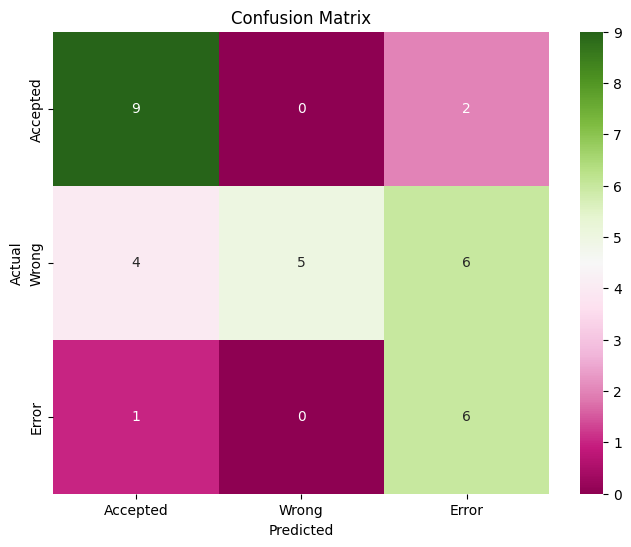

In [37]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test.values.argmax(axis=1), y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='PiYG',
            xticklabels=['Accepted', 'Wrong', 'Error'],
            yticklabels=['Accepted', 'Wrong', 'Error'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [40]:
# Define the hyperparameters you want to tune
param_grid = {
    'hidden_layer_sizes': [(40,), (40, 10)], #(40,)
    'activation' : ['logistic', 'tanh', 'relu'], #relu
    'solver' : ['sgd', 'adam'], # adam
    'alpha': [0.0001, 0.001, 0.01], #.0001
    'learning_rate': ['adaptive'],
    'max_iter': [1000],
}

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=MLPClassifier(),
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available CPU cores
    verbose=1,  # Print progress
    scoring='f1_micro'  # Use accuracy as the evaluation metric, if imbalanced use f1 score instead
)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_new, y_train_upsampled)

# Get the best hyperparameters found by GridSearchCV
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model found by GridSearchCV
best_model = grid_search.best_estimator_

cross_val_results = cross_val_score(best_model, X_new, y_train_upsampled, cv=kfold)
   
print(f'Cross-Validation Results (f1): {cross_val_results}')
print(f'Mean Accuracy: {cross_val_results.mean()}')

X_test_selected = selector.fit_transform(X_test, y_test.values.argmax(axis=1))

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test_selected)

# Generate and print the classification report
report = classification_report(y_test.values.argmax(axis=1), y_pred, zero_division=1)
print("SelectKBest ANN Classification Report:")
print(report)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


C:\Users\jobri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Best Hyperparameters: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (40, 10), 'learning_rate': 'adaptive', 'max_iter': 1000, 'solver': 'adam'}


C:\Users\jobri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jobri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jobri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jobr

Cross-Validation Results (f1): [0.63157895 0.78947368 0.84210526 0.73684211 0.89473684 0.52631579
 0.61111111 0.72222222 0.77777778 0.66666667]
Mean Accuracy: 0.7198830409356726
SelectKBest ANN Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.64      0.74        11
           1       0.79      0.73      0.76        15
           2       0.55      0.86      0.67         7

    accuracy                           0.73        33
   macro avg       0.74      0.74      0.72        33
weighted avg       0.76      0.73      0.73        33



C:\Users\jobri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


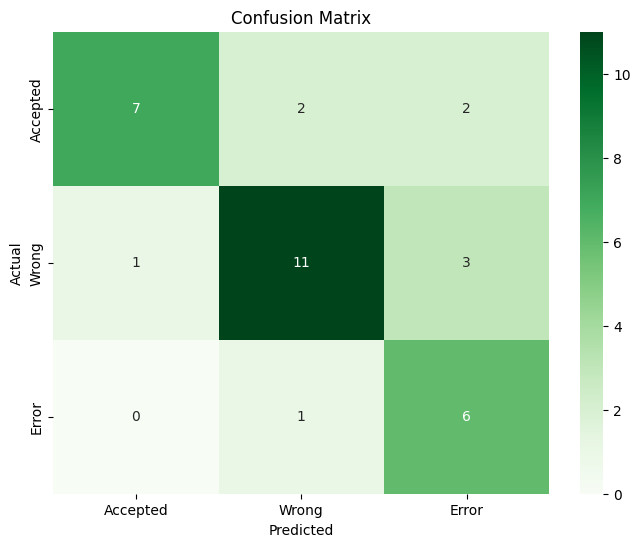

In [41]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test.values.argmax(axis=1), y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Accepted', 'Wrong', 'Error'],
            yticklabels=['Accepted', 'Wrong', 'Error'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()